## Import the requirements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import derl
from derl import EvalRunner, ActorCriticPolicy
from models import ContinuousActorCriticModel
from utils import make_mlp_class, parse_arg_archive
from visualization import state_action_obs_plot, plot_ltc_cell

/Users/renard/miniconda3/envs/nodeRL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/renard/miniconda3/envs/nodeRL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/renard/miniconda3/envs/nodeRL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/renard/miniconda3/envs/nodeRL/lib

## Instanciate the environment

In [2]:
tf.enable_eager_execution()

logdir = '/Users/renard/Documents/etudes/EPFLMA4/LTC/cluster_dump/experiments/R_InvertedPendulumLQReward_05061553/logdir/ltc/InvertedPendulumLQReward'
eval_steps = 128
render = True



run_args = parse_arg_archive(logdir + '/args.txt')

env = derl.env.make(run_args.env_id)
if hasattr(run_args, 'seed'):
    env.seed(run_args.seed)
policy = make_mlp_class(run_args.policy_net, run_args.recurrent_policy, run_args)(env.action_space.shape[0])
value = make_mlp_class(run_args.value_net, run_args.recurrent_value, run_args)(1)
model = ContinuousActorCriticModel(env.observation_space.shape,
                                    env.action_space.shape[0],
                                    policy, value)
model.load_weights(logdir+'/model') # load the weights from the logged policy
policy_object = ActorCriticPolicy(model)
runner = EvalRunner(env, policy_object, eval_steps, render)

/Users/renard/Documents/etudes/EPFLMA4/LTC/CTNN_Policies_DERL/derl/derl/env/summarize.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.had_ended_episodes = np.zeros(nenvs, dtype=np.bool)
2022-05-06 19:04:53.393213: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


## Run the experiment

In [4]:
trajectory = runner.get_next()

Creating window glfw
8643


## Plots

## Hidden state v.s env state

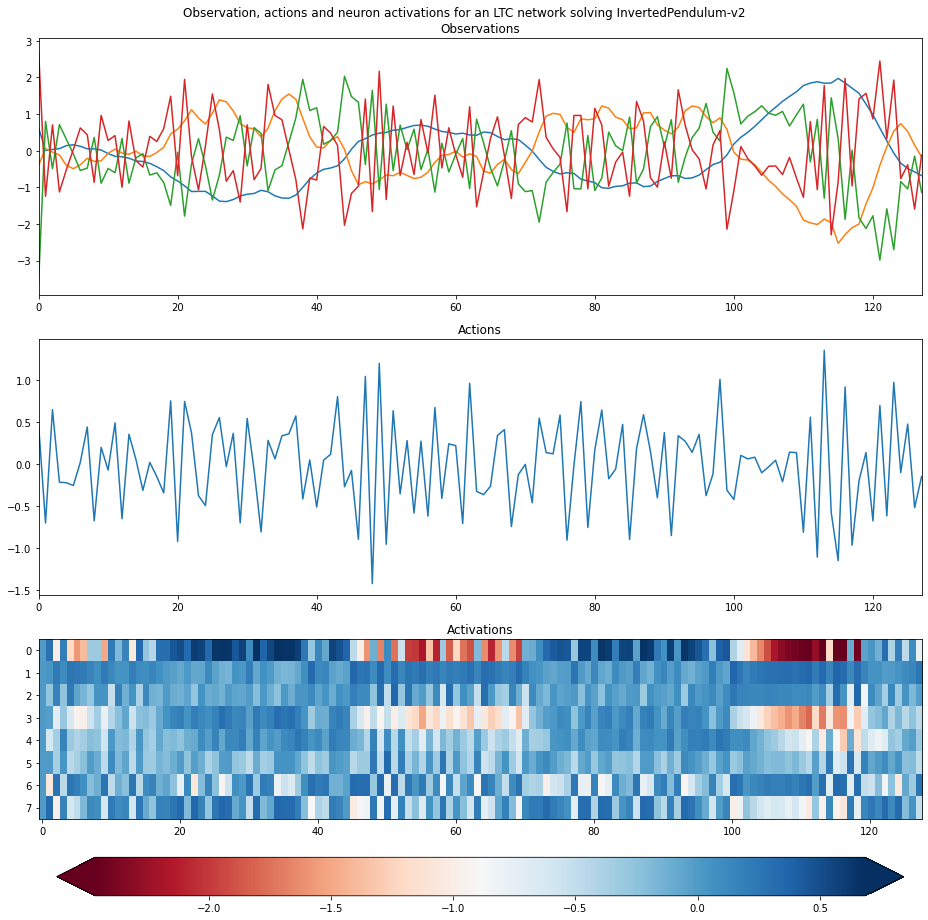

In [5]:
plt.rcParams["figure.figsize"]=13,13
state_action_obs_plot(trajectory)

## Activation Correlation

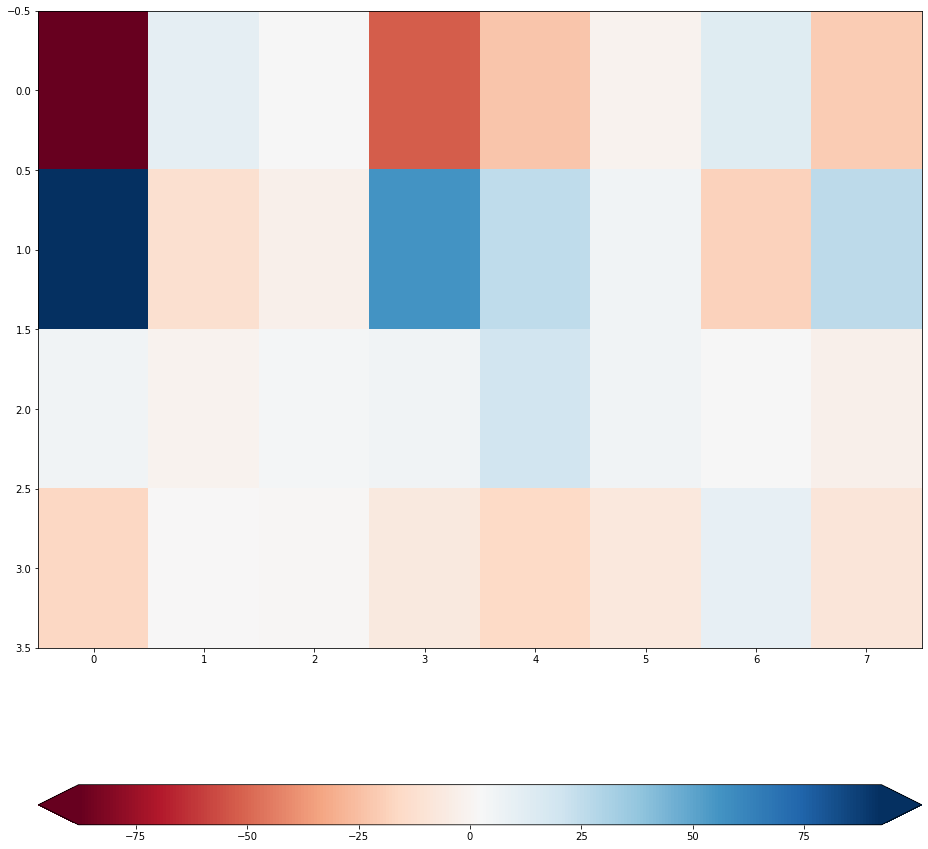

In [36]:
plt.rcParams["figure.figsize"]=13,13

obs = trajectory['observations']
act = trajectory['actions']
policy_states = trajectory['states'][:,0,0,:]
fig, ax = plt.subplots()

act_neuron = np.transpose(policy_states)

# state_0_corr = act_neuron*obs[:,0]
# state_1_corr = act_neuron*obs[:,1]
# state_2_corr = act_neuron*obs[:,2]
# state_3_corr = act_neuron*obs[:,3]
# act_corr = act_neuron*act[:,0]

out = []
for i in range(act_neuron.shape[0]):
    row = []
    for j in range(4):
        row.append(np.correlate(act_neuron[i,:],obs[:,j]))
    out.append(np.array(row))
out = np.array(out)[:,:,0]

activations = ax.imshow(np.transpose(out),aspect="auto", cmap='RdBu',interpolation = 'nearest')
_ = fig.colorbar(activations, ax=ax,orientation="horizontal", extend='both')

fig.tight_layout()
plt.show()

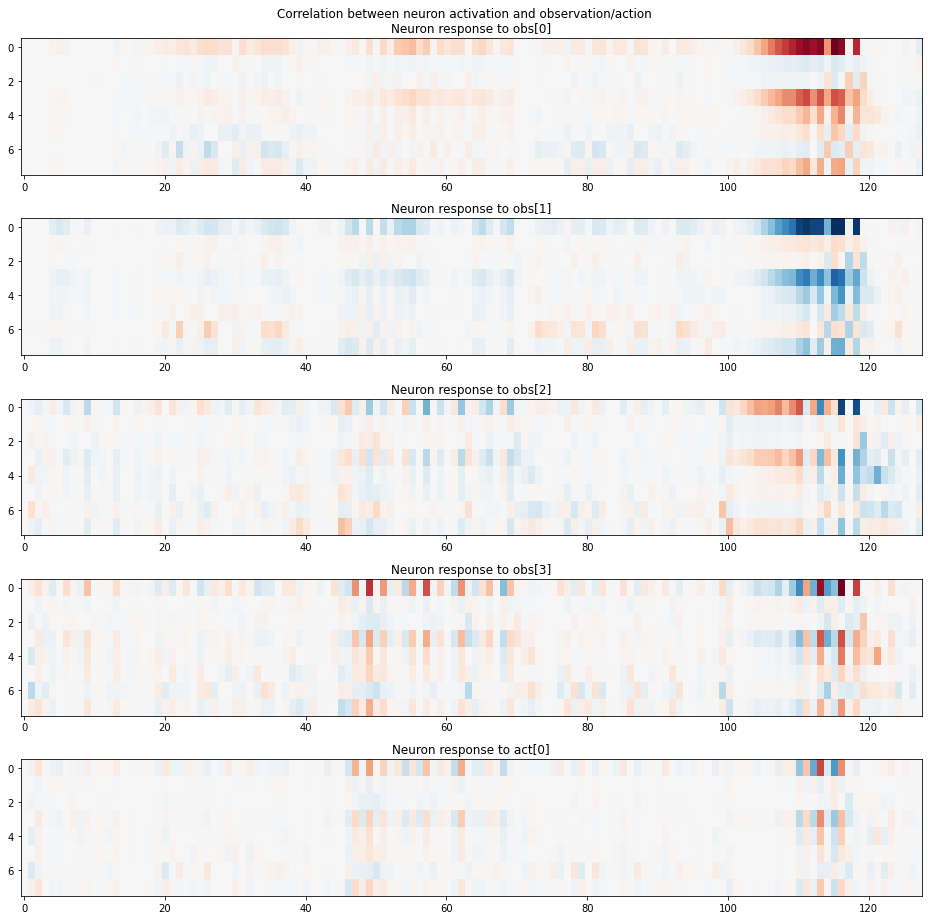

In [7]:
plt.rcParams["figure.figsize"]=13,13

obs = trajectory['observations']
act = trajectory['actions']
policy_states = trajectory['states'][:,0,0,:]
fig, axs = plt.subplots(5,1)

act_neuron = np.transpose(policy_states)

state_0_corr = act_neuron*obs[:,0]
state_1_corr = act_neuron*obs[:,1]
state_2_corr = act_neuron*obs[:,2]
state_3_corr = act_neuron*obs[:,3]
act_corr = act_neuron*act[:,0]

bounds = 5.

_cmap = 'RdBu'

activations_1 = axs[0].imshow(state_0_corr,aspect="auto", cmap=_cmap,interpolation = 'nearest',vmin=-bounds,vmax=bounds)
axs[0].set_title("Neuron response to obs[0]")
activations_1 = axs[1].imshow(state_1_corr,aspect="auto", cmap=_cmap,interpolation = 'nearest',vmin=-bounds,vmax=bounds)
axs[1].set_title("Neuron response to obs[1]")
activations_1 = axs[2].imshow(state_2_corr,aspect="auto", cmap=_cmap,interpolation = 'nearest',vmin=-bounds,vmax=bounds)
axs[2].set_title("Neuron response to obs[2]")
activations_1 = axs[3].imshow(state_3_corr,aspect="auto", cmap=_cmap,interpolation = 'nearest',vmin=-bounds,vmax=bounds)
axs[3].set_title("Neuron response to obs[3]")
activations_1 = axs[4].imshow(act_corr,aspect="auto", cmap=_cmap,interpolation = 'nearest',vmin=-bounds,vmax=bounds)
axs[4].set_title("Neuron response to act[0]")

fig.suptitle('Correlation between neuron activation and observation/action')

fig.tight_layout()


## LTC Cell vizulization

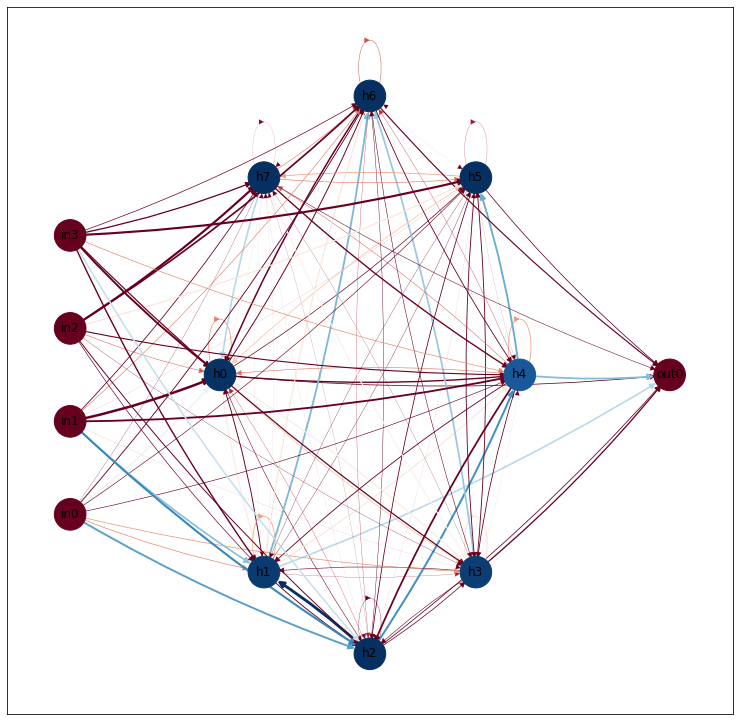

In [6]:
t = 100

obs = trajectory['observations'][t,:]
act = trajectory['actions'][t,:]
policy_states = trajectory['states'][t,0,0,:]


plot_ltc_cell(obs, act, policy_states, policy_object,node_size=1000)



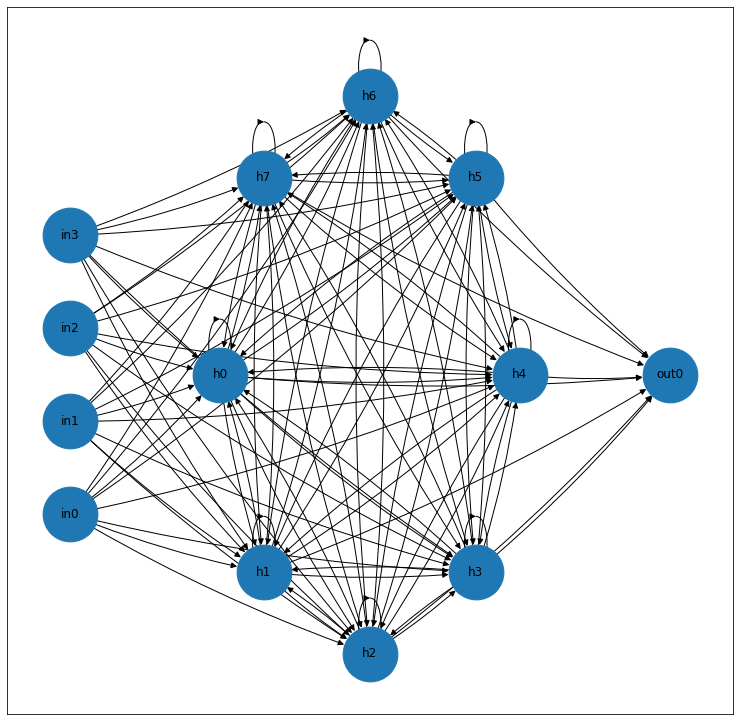

In [9]:
import networkx as nx
def plot_ltc_structure(inputs,hidden,outputs):
    _ccode = plt.get_cmap(_cmap)

    def network_to_nx(inputs,hidden,outputs):
        G = nx.DiGraph(directed=True)
        time_constant = policy_object.model.policy.weights[6].numpy()[0,:]
        
        for i in range(hidden):
            n = 'h{}'.format(i)
            G.add_node(n)
        for i in range(hidden):
            for j in range(hidden):
                G.add_edge('h{}'.format(i),'h{}'.format(j))  
        
        pos = nx.shell_layout(G)
        
        for i in range(inputs):
            n = 'in{}'.format(i)
            G.add_node(n)
            pos[n] = np.array([-2,  i/((inputs+2)/2) - 0.5 ])
        for i in range(outputs):
            n = 'out{}'.format(i)
            G.add_node(n, weight=1)
            pos[n] = np.array([2,  i/(outputs/2) ])
        
        for i in range(inputs):
            for j in range(hidden):
                G.add_edge('in{}'.format(i),'h{}'.format(j))  
        for i in range(hidden):
            for j in range(outputs):
                G.add_edge('h{}'.format(i),'out{}'.format(j))  
                
        return G, pos

    G, pos = network_to_nx(inputs,hidden,outputs)

        
    options = {
        'node_size': 3000,
        'arrowstyle': '-|>',
        'arrowsize': 12,
    }

    nx.draw_networkx(G,pos, arrows=True, **options,connectionstyle='arc3, rad = 0.05')
    plt.show()
    
plot_ltc_structure(4,8,1)